# Analysis of AirBNB Seattle dataset in 2016 for Coursera nanadegree

## 1. Business understanding
AirBNB has seen rapid development since it was founded in August 2008. It would be useful to analyze the host behavior and also get a sense of the growth of number of reviews in Seattle. This Jupyter notebook is trying to answer the following questions:

1. What does it mean to be a superhost?
2. What's relations between all price, weekly and montly price
3. Time series of amount of reviews

# 2. Data Understanding

Import modules, functions necessary for data analysis

In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from IPython.display import Image
from IPython.core.display import HTML 

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/reviews.csv


Function definition

In [70]:
def plot_bar_plots(df,col,cat_of_intest):
    """Plot box plots of a catergorical variable
    INPUT
    df: dataframe object of which the data is used to generate the plot
    col: column name of one of the df catergorical variable. This plot function will generate one box 
    for each level of this variable
    cat_of_intest: a list containing column names of df to be plotted
    """
    for i in cat_of_intest:
        pd.crosstab(df['host_is_superhost'], df[i],normalize='index').plot(kind='bar', stacked=True)
        plt.ylabel(i)
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.show()

In [71]:
# Read in data from csv files 
df_listings = pd.read_csv('/kaggle/input/seattle/listings.csv')
df_reviews = pd.read_csv('/kaggle/input/seattle/reviews.csv')
df_calendar = pd.read_csv('/kaggle/input/seattle/calendar.csv')

# show the calender data
print(df_calendar.head(5))

   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN


# 3. Data preparation

In [72]:
#1. Prepare dataframe to answer what it means to be a superhost 
# get dummy variable for the superhost variable. Transform the catergorical variable into a numerical variable, such that
# the correlation coefficient bewteen this variable and other numerical variables can be calculated
superhost_dum = pd.get_dummies(df_listings['host_is_superhost'],prefix = 'host_is_superhost',drop_first=True)
# concat the created dummy variable to the original dataframe
df_dum_superhost = pd.concat([df_listings,superhost_dum],axis=1)

#2. Prepare dataframe to analyze the relation between daily price, weekly price and monthly price
#get the columns related to price
price_cols = ['price','weekly_price','monthly_price']
# drop row with missing values. Can not compare the variation of prices if any of them is missing. 
df_price = df_listings[price_cols].dropna(subset = price_cols).reset_index(drop=True)
# change string to numbers
for i in price_cols:
    df_price[i] = df_price[i].str.replace(',', '').str.replace('$', '').astype(float)
    
# normalize the price to each day so that the daily prices can be compared
df_price['weekly_price'] = df_price['weekly_price']/7
df_price['monthly_price'] = df_price['monthly_price']/30
# The prices of each list can vary a lot, which makes it difficult to get the general picture
# Normalize the prices of each list by the daily price to a sense of percentage difference between the prices
for i in df_price.index:
    df_price.iloc[i] = df_price.iloc[i]/df_price.iloc[i]['price']

#3. Prepare dataframe to analyze the varation of the amount of reviews
df_ts = df_reviews.copy()
# Extract year/month data from the "date" column
df_ts['date_y_m'] = df_ts['date'].str[0:7]
# Extract month data from the "date" column
df_ts['date_m'] = df_ts['date'].str[5:7]

# 4. Data analysis

## 4.1 What does it mean to be a superhost?

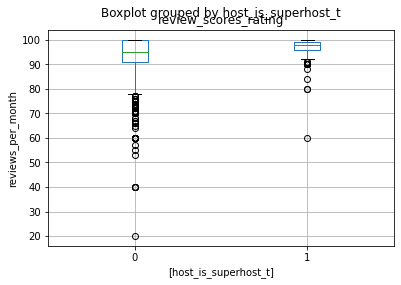

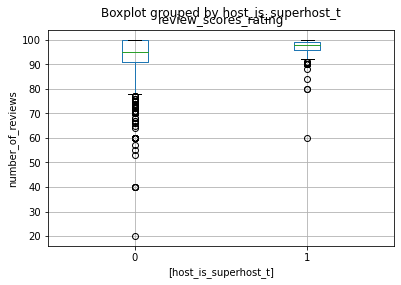

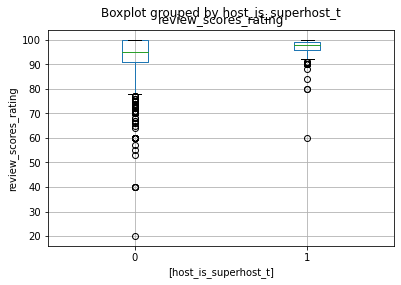

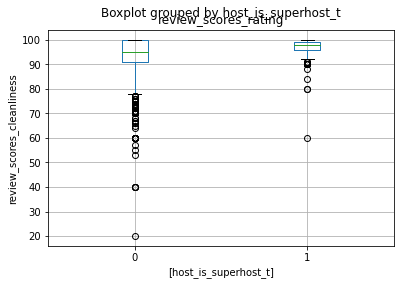

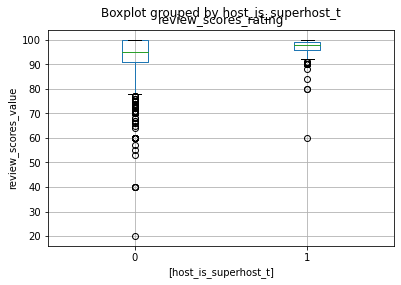

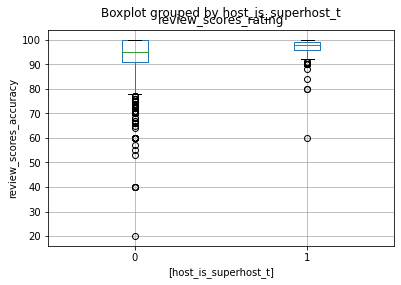

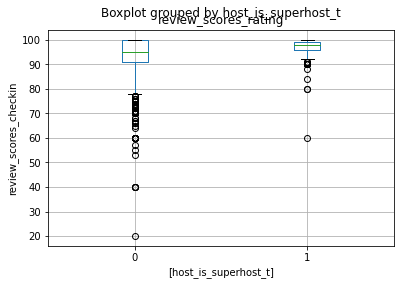

In [73]:
# calculate the correlation coefficients, then selects the values corresponding to the superhost catergorical variable
# The correltion coefficents are ordered in descending order. The top 10 variabls are selected for plotting
# Box plot is selected as it shows the distribution of all the data. It also gives a sense of mean value, variance and outlier. 
num_of_intest = df_dum_superhost.corr()['host_is_superhost_t'].abs().sort_values(ascending = False)[0:10].index
for i in num_of_intest[1:-2]:
    df_dum_superhost[['review_scores_rating','host_is_superhost_t']].boxplot(by='host_is_superhost_t')
    plt.ylabel(i)
    plt.show()

Whether or not a listing is superhost is mainly reflected by reviews. On average, superhost get more review and higher review scores with lower variance.

In [74]:
cat_of_intest = ['host_response_time','host_identity_verified','property_type','room_type',\
                 'instant_bookable','cancellation_policy','require_guest_profile_picture',\
                'require_guest_phone_verification']

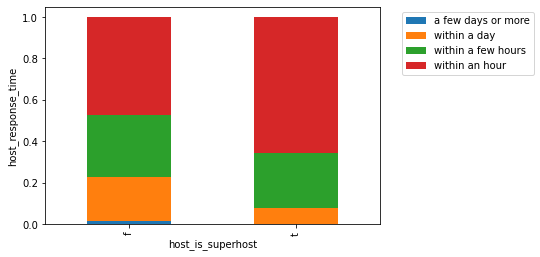

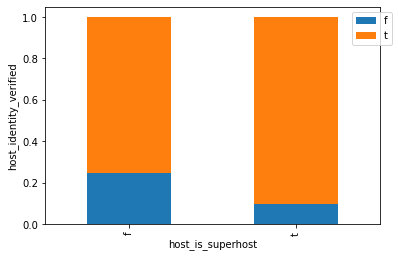

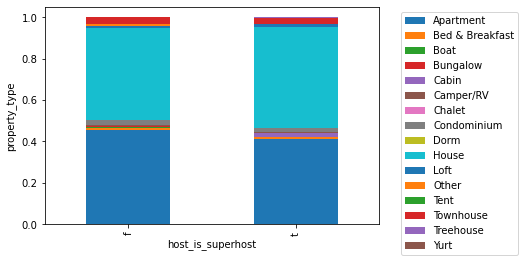

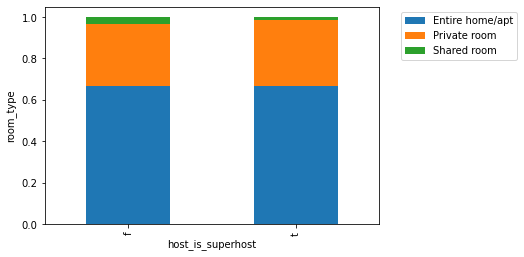

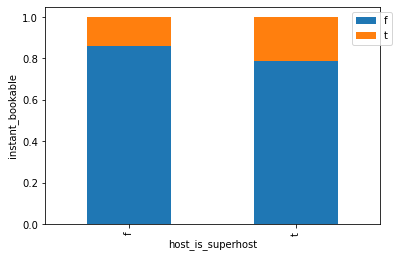

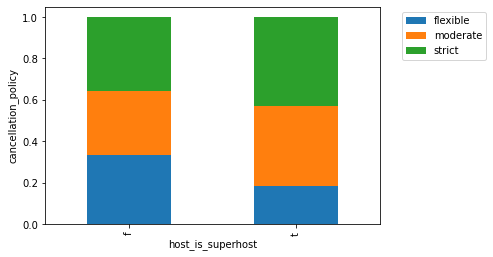

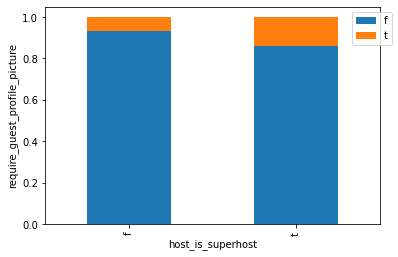

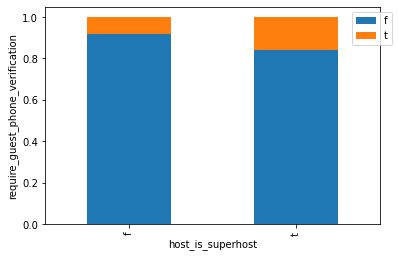

In [75]:
# plot box plots for superhost and non-superhost
# Each level of each variable is stack so that the percentage of each level is clear
plot_bar_plots(df_listings,'host_is_superhost',cat_of_intest)

The superhost subgroup will have a shorter reponse time. While customer generally prefer superhost with verified pictures, the superhost also prefer customers with some kind of verification. The superper host generally has a more strict cancnellation policy. While the proportions of property types are simiar for superhost and non-superhost, it does seem that it is very difficult to become a superhost if the room type is shared room. 

## 4.2 What's relations between daily price, weekly and montly price

Text(0, 0.5, 'Price/daily price')

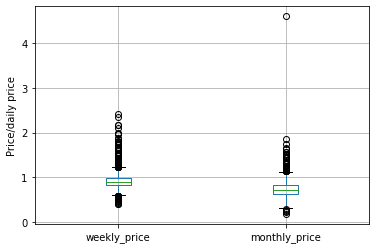

In [76]:
# plot box plots of the weekly price and monthly price, normalized by the daily price
boxplot = df_price.boxplot(column=['weekly_price', 'monthly_price'])
plt.ylabel('Price/daily price')

Generally, renting for a week or a month will lead to a lower daily price. However, this is not always the case. Some listing actually show increased price when renting for a longer time. 

## 4.3 Time series of amount of reviews

In [77]:
# group by the review by month and year, then count the number of reviews 
review_num = df_ts.groupby(['date_y_m']).date_y_m.count()

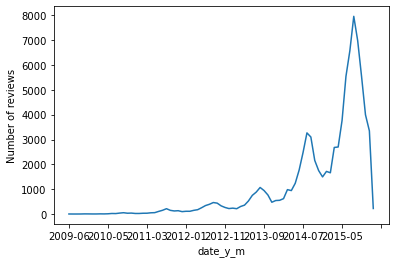

In [78]:
# plot the varition of number of reviews over time
review_num.plot()
plt.ylabel('Number of reviews')
plt.show()

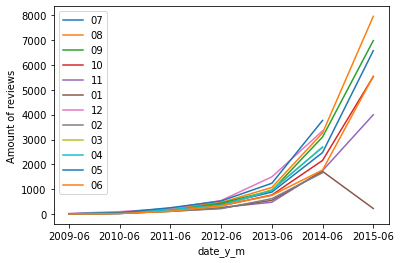

In [79]:
# seaonality makes the explation difficylt. Make plots based on month instead
for i in df_ts['date_m'].unique():
    # first select reviews in a given month. Then group the dataframe by year. Then count the number of reviews in each year
    review_num = df_ts[df_ts['date_m']==i].groupby(['date_y_m']).date_y_m.count()
    review_num.plot(label=i)
plt.legend()
plt.ylabel('Amount of reviews')
plt.show()

The number of reviews relfects the population of airbnb in the Seattle area. In 2009, the amount of reviews in Seattle is almost 0, which means that airbnb is not popular at that time. However, after that the amount of review increases rapidly to more than 1000 reviews every month. It also shows that July and August seem to be the most popular months, while November and January are the least popular months. 

# 5. Evaluation
* Being a superhost requires spending more time and effort on the property, such as shorter response time and a higher requirement for cleaniness.
* Being a superhost also bring benefits to the host, such as on average more guests visits and it allows the host to have a stricter cancellation policy, as the property is popular.
* Generatlly the renting price will be lower if the renting time is longer. However, this is not always the case. It may be interested to understand why for some properties the hosts are actually asking for more if the guest wants to rent for a longer time.
* AirBNB has seen rapid growth in Seatttle in the last few years. The time series of number of reviews show clear seasonality. Grouping the data by month in each year shows more clearly that number of reviews are growing every single year. 